In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelBinarizer, KBinsDiscretizer, OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer, MinMaxScaler, FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score
import warnings
warnings.filterwarnings('ignore')
from sklearn import __version__
__version__

'1.5.1'

# EDA

In [2]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

import io
df = pd.read_csv(io.BytesIO(uploaded[fn]))

### for local runtime

In [3]:
!ls

crime-cast-forecasting-crime-categories.zip  data  main.ipynb  submission.csv


In [4]:
df = pd.read_csv('data/train.csv')

In [5]:
df.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [23]:
df.Victim_Age[(df.Victim_Age <= 0)]

4        0.0
6        0.0
8        0.0
12       0.0
15       0.0
        ... 
19989    0.0
19991    0.0
19993    0.0
19996    0.0
19999    0.0
Name: Victim_Age, Length: 4834, dtype: float64

In [6]:
len(df.columns)

22

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [11]:
df.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,7335.000000
mean,33.940704,-117.893072,1352.380350,10.834250,1129.599200,1.418150,30.135000,297.176950,366.405044
std,2.126810,7.377726,646.100291,6.033166,603.330519,0.493267,21.863645,212.007298,120.485687
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.323000,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165025,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


In [12]:
df.Crime_Category.unique()

array(['Property Crimes', 'Violent Crimes', 'Other Crimes',
       'Crimes against Public Order', 'Fraud and White-Collar Crimes',
       'Crimes against Persons'], dtype=object)

In [28]:
df.columns = df.columns.map(lambda x: '_'.join(x.lower().split(' ')))

In [52]:
df.columns

Index(['location', 'cross_street', 'latitude', 'longitude', 'date_reported',
       'date_occurred', 'time_occurred', 'area_id', 'area_name',
       'reporting_district_no', 'part_1-2', 'modus_operandi', 'victim_age',
       'victim_sex', 'victim_descent', 'premise_code', 'premise_description',
       'weapon_used_code', 'weapon_description', 'status',
       'status_description', 'crime_category'],
      dtype='object')

# Preprocessing

#### Spliting train and test sets

In [30]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

In [32]:
X_train.shape, X_test.shape

((16000, 21), (4000, 21))

In [58]:
class CustomModification(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mlb = MultiLabelBinarizer()
        modus_operandi = X['modus_operandi'].map(lambda x: () if type(x) == float else tuple(map(int,x.split(' '))))
        self.mlb.fit(modus_operandi)
        return self

    def transform(self, X, y=None):
        X = X.copy()
        self.clean(X)

        X.insert(4, 'reported_year', X['date_reported'].dt.year)
        X.insert(4, 'reported_month', X['date_reported'].dt.month)
        X.insert(4, 'reported_day', X['date_reported'].dt.day)

        X.insert(8, 'occurred_year', X['date_occurred'].dt.year)
        X.insert(8, 'occurred_month', X['date_occurred'].dt.month)
        X.insert(8, 'occurred_day', X['date_occurred'].dt.day)


        X.insert(X.columns.get_loc('modus_operandi'), 'mo_count', X['modus_operandi'].map(len))

        MO = self.mlb.transform(X['modus_operandi'])
        MO = pd.DataFrame(MO, index=X.index)
        MO.columns = MO.columns.map(lambda x: 'mo_' + str(x))
        X = pd.concat([X.iloc[:, :X.columns.get_loc('modus_operandi')], MO, X.iloc[:, X.columns.get_loc('modus_operandi'):]], axis=1)

        X = X.drop(['date_reported', 'date_occurred', 'modus_operandi', 'location', 'cross_street', 'area_name', 'premise_description', 'weapon_description', 'status_description'], axis=1)
        return X

    def clean(self, X):
      # X["Latitude"] = X['Latitude'].map(lambda x: np.nan if x == 0 else x)
      # X["Longitude"] = X['Longitude'].map(lambda x: np.nan if x == 0 else x)
      X['date_reported'] = pd.to_datetime(X['date_reported'], format='%m/%d/%Y %H:%M:%S %p')
      X['date_occurred'] = pd.to_datetime(X['date_occurred'], format='%m/%d/%Y %H:%M:%S %p')
      X.loc[X['victim_age'] < 0, 'victim_age'] = 0
      X["modus_operandi"] = X['modus_operandi'].map(lambda x: () if type(x) == float else tuple(map(int,x.split(' '))))



In [46]:
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore', min_frequency=0.05)),
])
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('encoder', KBinsDiscretizer(strategy='kmeans', encode='onehot-dense')),
])

In [60]:
CustomModification().fit_transform(X_train).shape

(16000, 475)

In [59]:
make_pipeline(CustomModification()).fit_transform(X_train).columns

Index(['latitude', 'longitude', 'reported_day', 'reported_month',
       'reported_year', 'occurred_day', 'occurred_month', 'occurred_year',
       'time_occurred', 'area_id',
       ...
       'mo_452', 'mo_453', 'mo_454', 'mo_455', 'victim_age', 'victim_sex',
       'victim_descent', 'premise_code', 'weapon_used_code', 'status'],
      dtype='object', length=475)

In [ ]:
pre_proc = ColumnTransformer([
  ('ofe', OrdinalEncoder(), [10]),
  ('ofe', OneHotEncoder(min_frequency=0.05, handle_unknown='ignore', sparse_output=False), ['victim_sex', 'victim_descent']),
  ('ss', StandardScaler(with_mean=True, with_std=True), ['latitude', 'longitude',]),
  ('cp1', cat_pipe, [13, 14]),
  ('mms', MinMaxScaler(), ['reported_day', 'reported_month', 'reported_year', 'occurred_day', 'occurred_month', 'occurred_year' ])),
  ('loc', num_pipe, [2, 3]),
  ('uofe', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist', min_frequency=0.05), [7,9,15,17,19]),
], remainder='drop').set_output(transform='pandas')

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.fit_transform(y_test)

In [ ]:
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.fit_transform(y_test)

In [ ]:
pipe1 = make_pipeline(CustomModification(), pre_proc, GaussianNB())

In [ ]:
pipe2 = make_pipeline(CustomModification(), pre_proc, DecisionTreeClassifier())

In [ ]:
pipe3 = make_pipeline(CustomModification(), pre_proc, RandomForestClassifier(random_state=0))

In [ ]:
pipe4 = make_pipeline(CustomModification(), pre_proc, LogisticRegression(solver='liblinear',penalty='l1'))
# pipe4 = make_pipeline(CustomModification(), pre_proc, LogisticRegression())

In [ ]:
pipe5 = make_pipeline(CustomModification(), pre_proc, SGDClassifier())

In [ ]:
print('GaussianNB')
pipe1.fit(X_train, y_train_enc)
trs_gnb = pipe1.score(X_train, y_train_enc)
tes_gnb = pipe1.score(X_test, y_test_enc)
print('Training Score: ', trs_gnb)
print('Testing Score: ', tes_gnb)

GaussianNB
Training Score:  0.3340625
Testing Score:  0.312


In [ ]:
print('Decision Tree Classifier')
print('Label Encode Ordinaly')
pipe2.fit(X_train, y_train_enc)
print('Training Score: ', pipe2.score(X_train, y_train_enc))
print('Testing Score: ', pipe2.score(X_test, y_test_enc))
print()
print('Label Binarized')
pipe2.fit(X_train, y_train_bin)
print('Training Score: ', pipe2.score(X_train, y_train_bin))
print('Testing Score: ', pipe2.score(X_test, y_test_bin))

Decision Tree Classifier
Label Encode Ordinaly
Training Score:  1.0
Testing Score:  0.92575

Label Binarized
Training Score:  1.0
Testing Score:  0.9255


In [ ]:
print('Random Forest Classifier')

print('Label Encode Ordinaly')
pipe3.fit(X_train, y_train_enc)
print('Training Score: ', pipe3.score(X_train, y_train_enc))
print('Testing Score: ', pipe3.score(X_test, y_test_enc))
print()

print('Label Binarized')
pipe3.fit(X_train, y_train_bin)
print('Training Score: ', pipe3.score(X_train, y_train_bin))
print('Testing Score: ', pipe3.score(X_test, y_test_bin))
print()

print('Cross-validation')
cvl = cross_val_score(pipe3, X, y, cv=skf, scoring='accuracy')
print('CV_score, std: ', cvl.mean(), cvl.std())

Random Forest Classifier
Label Encode Ordinaly
Training Score:  1.0
Testing Score:  0.94625

Label Binarized
Training Score:  1.0
Testing Score:  0.9205

Cross-validation
CV_score, std:  0.94575 0.0028328430948430863


In [ ]:
print('Logistic Regression')
pipe4.fit(X_train, y_train_enc)
print('Training Score: ', pipe4.score(X_train, y_train_enc))
print('Testing Score: ', pipe4.score(X_test, y_test_enc))

cvl = cross_val_score(pipe4, X, y, cv=skf, scoring='accuracy')
print('CV_score: ', cvl.mean())

Logistic Regression
Training Score:  0.9555
Testing Score:  0.951
CV_score:  0.9497


In [ ]:
print('SGDClassifier')
pipe5.fit(X_train, y_train_enc)
print('Training Score: ', pipe5.score(X_train, y_train_enc))
print('Testing Score: ', pipe5.score(X_test, y_test_enc))

cvl = cross_val_score(pipe4, X, y, cv=skf, scoring='accuracy')
print('CV_score, std: ', np.round(cvl.mean(), 4), np.round(cvl.std(), 4))

SGDClassifier
Training Score:  0.9543125
Testing Score:  0.946
CV_score, std:  0.9496 0.0025


In [ ]:
pipe = Pipeline([
    ('custom',  CustomModification()),
    ('pre_process', pre_proc),
    ('classifier', BaggingClassifier(estimator=DecisionTreeClassifier()))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

param_grid = {
    'classifier__max_samples': [0.2, 0.6, 1.0],
    'classifier__max_features': [2, 5, 0.5, 1.0],
    'classifier__bootstrap': [True, False],
    'classifier__bootstrap_features': [True, False],
    'classifier__n_estimators': [10, 20, 50],
}

grid_search = GridSearchCV(pipe, param_grid, cv=skf, scoring='accuracy')
grid_search.fit(X, y)

print("Best Parameters: ", grid_search.best_params_)
print("Best Parameters: ", grid_search.best_score_)

Best Parameters:  {'classifier__bootstrap': False, 'classifier__bootstrap_features': True, 'classifier__max_features': 1.0, 'classifier__max_samples': 1.0, 'classifier__n_estimators': 50}


In [ ]:
bgcv = make_pipeline(CustomModification(), pre_proc, BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=80,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=False,
    bootstrap_features=True,
    random_state=0
))
cvl = cross_val_score(bgcv, X, y, cv=skf, scoring='accuracy')
m, s = cvl.mean(), cvl.std()
model_report = pd.DataFrame(dict(BaggingClassifier_best=[m, s]), index=['Mean', 'Std'])

In [ ]:
model_report.transpose().head(1)

,Mean,Std
Bagging_Classifier_Best,0.9525,0.002302


In [ ]:
pipe = Pipeline([
    ('custom',  CustomModification()),
    ('pre_process', pre_proc),
    ('classifier', SGDClassifier(early_stopping=True))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

param_grid = {
    'classifier__max_iter': [100, 500],
    'classifier__penalty': ['elasticnet'],
    'classifier__learning_rate': ['optimal', 'invscaling'],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__l1_ratio': [0.1, 0.15, 0.2],
    'classifier__average': [True, False],
    'classifier__validation_fraction': [0.05, 0.1, 0.15],
    'classifier__epsilon': [0.1, 0.15, 0.2],
}

grid_search = GridSearchCV(pipe, param_grid, cv=skf, scoring='accuracy')
grid_search.fit(X, y)

print("Best Parameters: ", grid_search.best_params_)
print("Best Parameters: ", grid_search.best_score_)

Best Parameters:  {'classifier__average': False, 'classifier__class_weight': None, 'classifier__epsilon': 0.1, 'classifier__l1_ratio': 0.15, 'classifier__learning_rate': 'optimal', 'classifier__max_iter': 500, 'classifier__penalty': 'elasticnet', 'classifier__validation_fraction': 0.05}
Best Parameters:  0.9464


In [ ]:
grid_search.best_estimator_[-1].n_iter_

13

In [ ]:
sgdc = make_pipeline(CustomModification(), pre_proc, SGDClassifier(
    early_stopping=True,
    validation_fraction=0.05,
    max_iter=100,
    penalty='elasticnet',
))
cvl = cross_val_score(sgdc, X, y, cv=skf, scoring='accuracy')
m, s = cvl.mean(), cvl.std()
model_report['SGDClassifier_best'] = [m, s]

In [ ]:
model_report.transpose()

,Mean,Std
Bagging_Classifier_Best,0.9525,0.002302
SGDClassifier_best,0.9419,0.002513


In [ ]:
bgcv.fit(X_train, y_train_enc)
bgcv_pred = bgcv.predict(X_test)
sgdc.fit(X_train, y_train_enc)
sgdc_pred = sgdc.predict(X_test)

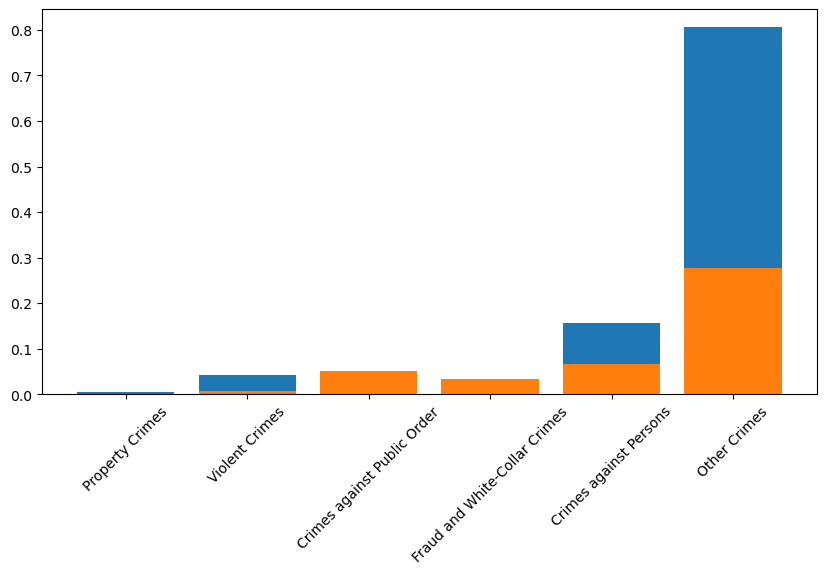

In [ ]:
pred_by_acc_bgcv = np.abs((pd.Series(le.inverse_transform(bgcv_pred.reshape(-1, 1))).value_counts() / y_test.value_counts()) -1)
pred_by_acc_sgdc = np.abs((pd.Series(le.inverse_transform(sgdc_pred.reshape(-1, 1))).value_counts() / y_test.value_counts()) -1)

plt.figure(figsize=(10, 5))
plt.bar(pred_by_acc_bgcv.index, pred_by_acc_bgcv.values)
plt.bar(pred_by_acc_sgdc.index, pred_by_acc_sgdc.values)
plt.xticks(rotation=45)
plt.show()

In [ ]:
vc = make_pipeline(CustomModification(), pre_proc, VotingClassifier(estimators=[('bgcv', BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=80,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=False,
    bootstrap_features=True,
    random_state=0
)),
('lr', LogisticRegression(solver='liblinear',penalty='l1'))], voting='soft', weights = [0.9525, 0.9497]))

cvl = cross_val_score(vc, X, y, cv=skf, scoring='accuracy')
m, s = cvl.mean(), cvl.std()
model_report['VotingClassifier_best'] = [m, s]

In [ ]:
model_report.transpose()

,Mean,Std
Bagging_Classifier_Best,0.95250,0.002302
SGDClassifier_best,0.94190,0.002513
VotingClassifier_best,0.95475,0.003166


# Final

In [ ]:
model = vc

In [ ]:
model = grid_search.best_estimator_

Pipeline(steps=[('custom', CustomModification()),
                ('pre_process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dropper', 'drop',
                                                  [0, 1, 4, 5, 8, 10, 11, 16,
                                                   18, 20]),
                                                 ('ofe', OrdinalEncoder(),
                                                  [10]),
                                                 ('ss', StandardScaler(),
                                                  [6, 12]),
                                                 ('cp1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infreque...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('encoder',
                                                                   KBinsDiscretizer(encode='onehot-dense',
                                                                                    strategy='kmeans'))]),
                                                  [2, 3]),
                                                 ('uofe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.05,
                                                                sparse_output=False),
                                                  [7, 9, 15, 17, 19])])),
                ('classifier',
                 BaggingClassifier(bootstrap=False, bootstrap_features=True,
                                   estimator=DecisionTreeClassifier(),
                                   n_estimators=50))])

In [ ]:
model.fit(X, y)

Pipeline(steps=[('custommodification', CustomModification()),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dropper', 'drop',
                                                  [0, 1, 4, 5, 8, 10, 11, 16,
                                                   18, 20]),
                                                 ('ofe', OrdinalEncoder(),
                                                  [10]),
                                                 ('ss', StandardScaler(),
                                                  [6, 12]),
                                                 ('cp1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle...
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.05,
                                                                sparse_output=False),
                                                  [7, 9, 15, 17, 19])])),
                ('votingclassifier',
                 VotingClassifier(estimators=[('bgcv',
                                               BaggingClassifier(bootstrap=False,
                                                                 bootstrap_features=True,
                                                                 estimator=DecisionTreeClassifier(),
                                                                 n_estimators=80,
                                                                 random_state=0)),
                                              ('lr',
                                               LogisticRegression(penalty='l1',
                                                                  solver='liblinear'))],
                                  voting='soft', weights=[0.9525, 0.9497]))])

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
import io
Xt = pd.read_csv(io.BytesIO(uploaded[fn]))

ModuleNotFoundError: No module named 'google'

In [ ]:
# for local runtime
Xt = pd.read_csv('data/test.csv')

In [ ]:
prediction = model.predict(Xt)

In [ ]:
# sub = pd.DataFrame(prediction, index=Xt.index, columns=['Crime_Category'])
sub = pd.DataFrame()
sub['Crime_Category'] = prediction
sub.index += 1
sub.index.name = 'ID'
# sub['Crime_Category'] = prediction

In [ ]:
sub.to_csv('submission.csv')
files.download('submission.csv')

NameError: name 'files' is not defined

In [ ]:
# for local runtime
sub.to_csv('./submission.csv')